In [9]:
import pandas as pd
columns = [
        "age", "workclass", "fnlwgt", "education", "education-num",
        "marital-status", "occupation", "relationship", "race", "sex",
        "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"
    ]

# Load the .txt file (comma-separated)
df = pd.read_csv('../datasets/adult/adult.data', names=columns, sep=r'\s*,\s*', engine='python', skiprows=1)
df_test = pd.read_csv("../datasets/adult/adult.test",names=columns, sep=r'\s*,\s*', engine='python', skiprows=1)


In [10]:
# Create training and testing variables
Y_train = (df["income"] == ">50K").astype(int)
Y_sen_train = (df["sex"] == "Female").astype(int)   # Encode sex: Female -> 1, Male -> 0
X_train = df.drop(columns=["sex", "income", "fnlwgt"])      # Prepare X_train (features without sensitive attribute and without target)
X_train = pd.get_dummies(X_train, drop_first=True)      # One-hot encode categorical variables

Y_test = (df_test["income"] == ">50K.").astype(int)
Y_sen_test = (df_test["sex"] == "Female").astype(int)

X_test = df_test.drop(columns=["sex", "income", "fnlwgt"])
X_test = pd.get_dummies(X_test, drop_first=True)

# Align columns
X_train, X_test = X_train.align(X_test, join="left", axis=1)

# Fill NaNs from missing categories in test with 0
X_test = X_test.fillna(0)
Y_test = Y_test.loc[X_test.index]
Y_sen_test = Y_sen_test.loc[X_test.index]

In [22]:
# Create training and testing variables
Y_train = (df["income"] == ">50K").astype(int)
Y_sen_train = (df["sex"] == "Female").astype(int)   # Encode sex: Female -> 1, Male -> 0
X_train = df.drop(columns=["sex", "income", "fnlwgt"])      # Prepare X_train (features without sensitive attribute and without target)
X_train = pd.get_dummies(X_train, drop_first=True)      # One-hot encode categorical variables

Y_test = (df_test["income"] == ">50K").astype(int)
Y_sen_train = (df["sex"] == "Female").astype(int)
X_test = df_test.drop(columns=["sex", "income", "fnlwgt"])
X_test = pd.get_dummies(X_test, drop_first=True)

In [26]:
type(Y_sen_test)

pandas.core.series.Series

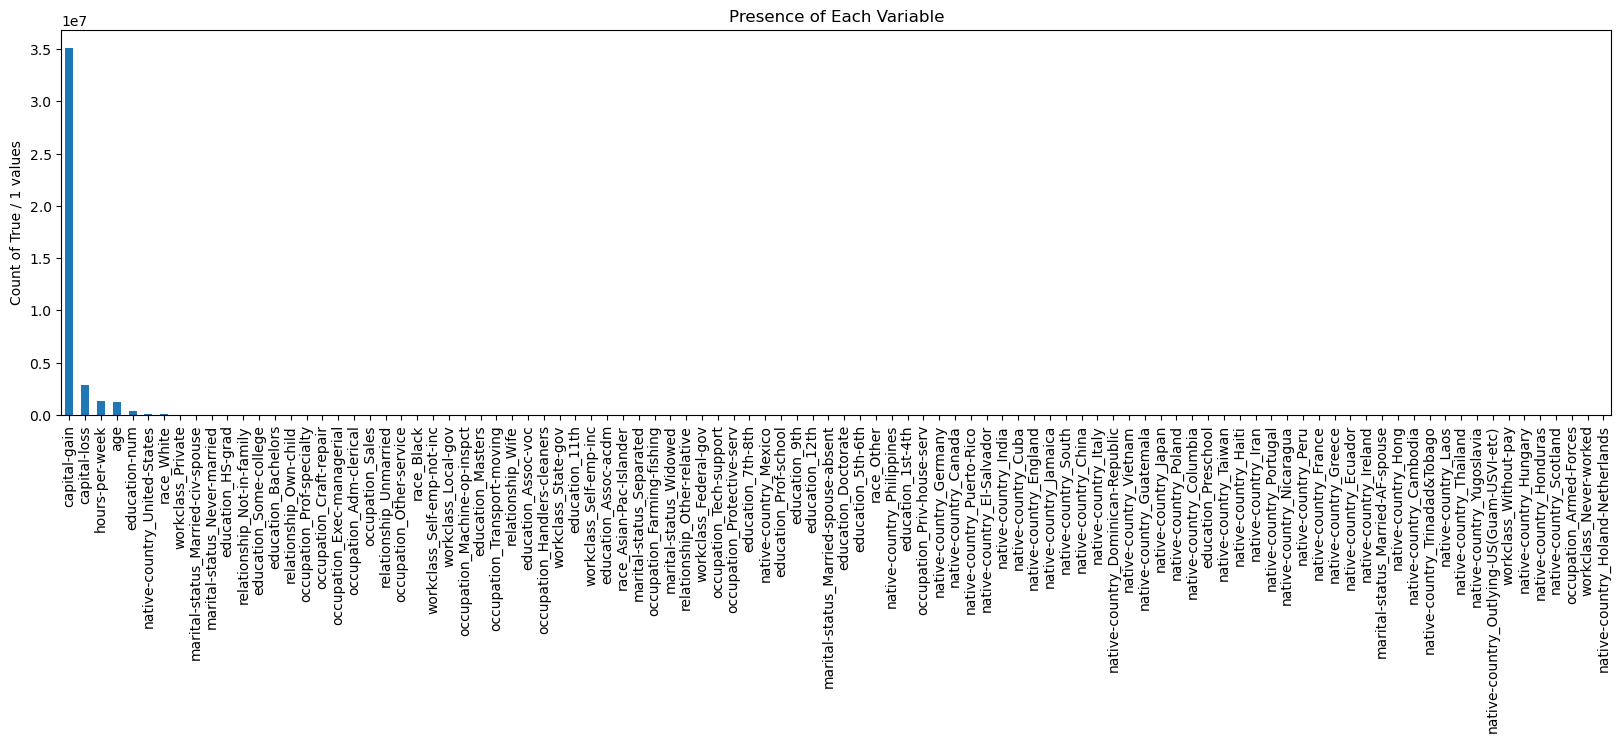

In [3]:
counts = X_train.sum()
counts.sort_values(ascending=False).plot(kind="bar", figsize=(20,5))
plt.ylabel("Count of True / 1 values")
plt.title("Presence of Each Variable")
plt.show()

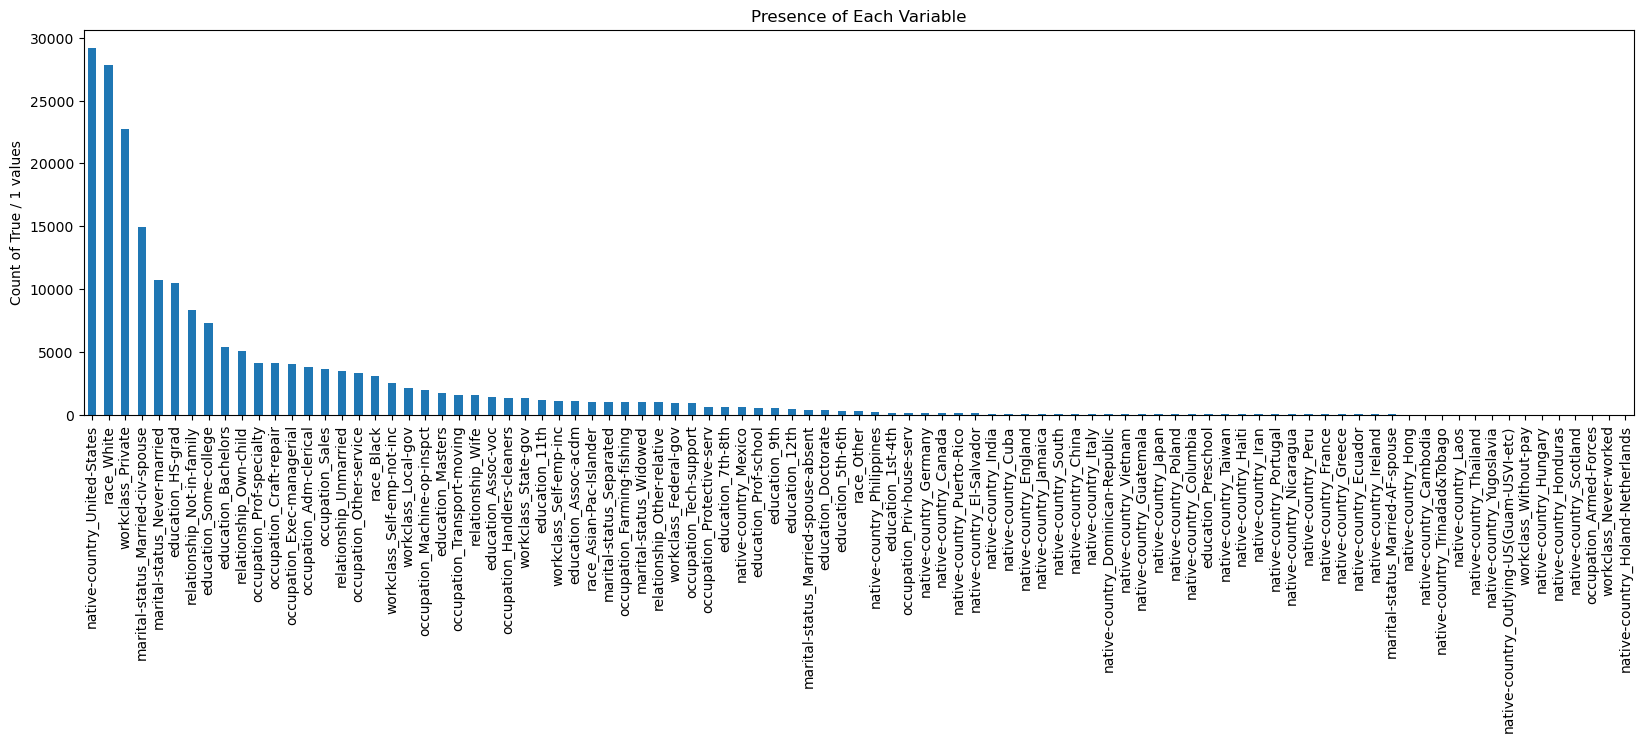

In [4]:
X_train = X_train.drop(columns=["capital-gain","capital-loss", "hours-per-week", "age", "education-num"])
counts = X_train.sum()
counts.sort_values(ascending=False).plot(kind="bar", figsize=(20,5))
plt.ylabel("Count of True / 1 values")
plt.title("Presence of Each Variable")
plt.show()